# **Part A**
Count / Frequency based Naive Bayes Classifier

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# Completed Implementation of Naive Bayes Classifier
# =======================================================


# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # ✅ TODO 1: Calculate log prior
            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])

            # ✅ Calculate counts and total tokens
            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # ✅ TODO 2: Calculate numerator (Laplace smoothing)
            numerator = feature_sum + self.alpha

            # ✅ TODO 3: Calculate denominator (Laplace smoothing)
            denominator = total_mass + self.alpha * self.vocabulary_size

            # ✅ TODO 4: Calculate log likelihoods
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}
            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                # ✅ TODO 5: Add log likelihood contributions
                non_zero_indices = x_i.indices
                non_zero_data = x_i.data
                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])

                scores[c] = log_prob

            # ✅ TODO 6: Find class with max score
            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)

        # ✅ TODO 7: Return predictions
        return np.array(y_pred)


In [12]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = 'D:\ML_7\Dataset'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    # train_df = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # dev_df   = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # test_df  = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})


    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [13]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        ngram_range=(1, 2),  # ✅ use unigrams + bigrams for richer features
        min_df=2             # ✅ ignore rare words appearing in <2 documents
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # ✅ Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # ✅ Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)

    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    # ✅ Initialize the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # ✅ Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")


Fitting Count Vectorizer and transforming training data...
Vocabulary size: 301234
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [14]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# ✅ Predict y_test_pred using X_test_counts
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")



=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7571
              precision    recall  f1-score   support

  BACKGROUND       0.57      0.56      0.57      3621
 CONCLUSIONS       0.63      0.69      0.66      4571
     METHODS       0.81      0.89      0.85      9897
   OBJECTIVE       0.60      0.43      0.50      2333
     RESULTS       0.87      0.80      0.84      9713

    accuracy                           0.76     30135
   macro avg       0.70      0.68      0.68     30135
weighted avg       0.76      0.76      0.75     30135

Macro-averaged F1 score: 0.6825


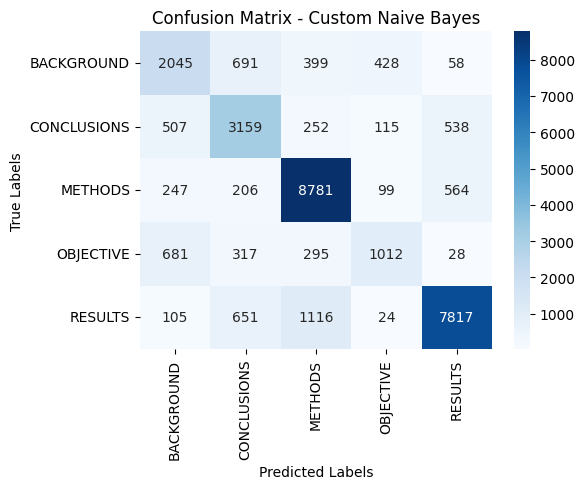

In [15]:
# Confusion Matrix on test set
if y_test_pred is not None:
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)

    plt.title('Confusion Matrix - Custom Naive Bayes')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot confusion matrix — prediction step incomplete.")


# **Part B**
TF-IDF score based Classifier

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# 1. Define pipeline
# =======================================================
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        stop_words='english'
    )),
    ('nb', MultinomialNB())
])

# =======================================================
# 2. Train initial pipeline
# =======================================================
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")

# =======================================================
# 3. Predict & Evaluate
# =======================================================
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred, target_names=target_names))
print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")

# =======================================================
# 4. Define Parameter Grid for Hyperparameter Tuning
# =======================================================
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],   # Unigrams and bigrams
    'tfidf__min_df': [1, 3, 5],               # Ignore rare words
    'nb__alpha': [0.1, 0.5, 1.0]              # Laplace smoothing parameter
}

# =======================================================
# 5. Initialize GridSearchCV
# =======================================================
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("\nStarting Hyperparameter Tuning on Development Set...")

# =======================================================
# 6. Fit GridSearchCV on Dev Data
# =======================================================
grid.fit(X_dev, y_dev)
print("Grid search complete.")

# =======================================================
# 7. Display Best Parameters and Score
# =======================================================
print("\nBest Parameters Found:")
print(grid.best_params_)
print(f"Best Cross-Validation F1 Score: {grid.best_score_:.4f}")


Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.6996
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.37      0.46      3621
 CONCLUSIONS       0.61      0.55      0.57      4571
     METHODS       0.68      0.88      0.77      9897
   OBJECTIVE       0.72      0.09      0.16      2333
     RESULTS       0.77      0.85      0.81      9713

    accuracy                           0.70     30135
   macro avg       0.68      0.55      0.56     30135
weighted avg       0.69      0.70      0.67     30135

Macro-averaged F1 score: 0.5555

Starting Hyperparameter Tuning on Development Set...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Grid search complete.

Best Parameters Found:
{'nb__alpha': 0.1, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation F1 Score: 0.6308


# **Part C**
Bayes Optimal Classifier

Part C Draft

Using dynamic sample size: 10170
Actual sampled training set size used: 10170

Training all base models...
→ Training NaiveBayes ...
→ Training LogisticRegression ...


d:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


→ Training RandomForest ...
→ Training DecisionTree ...
→ Training KNN ...
All base models trained successfully.

Calculating posterior weights (P(h|D))...
NaiveBayes validation accuracy: 0.8073
LogisticRegression validation accuracy: 0.7965
RandomForest validation accuracy: 0.6785
DecisionTree validation accuracy: 0.4926
KNN validation accuracy: 0.5998

Posterior Weights (normalized): [0.239, 0.236, 0.201, 0.146, 0.178]

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.6972
              precision    recall  f1-score   support

  BACKGROUND       0.59      0.31      0.41      3621
 CONCLUSIONS       0.60      0.52      0.56      4571
     METHODS       0.68      0.90      0.77      9897
   OBJECTIVE       0.69      0.33      0.44      2333
     RESULTS       0.78      0.81      0.80      9713

    accuracy                           0.70     30135
   macro avg  

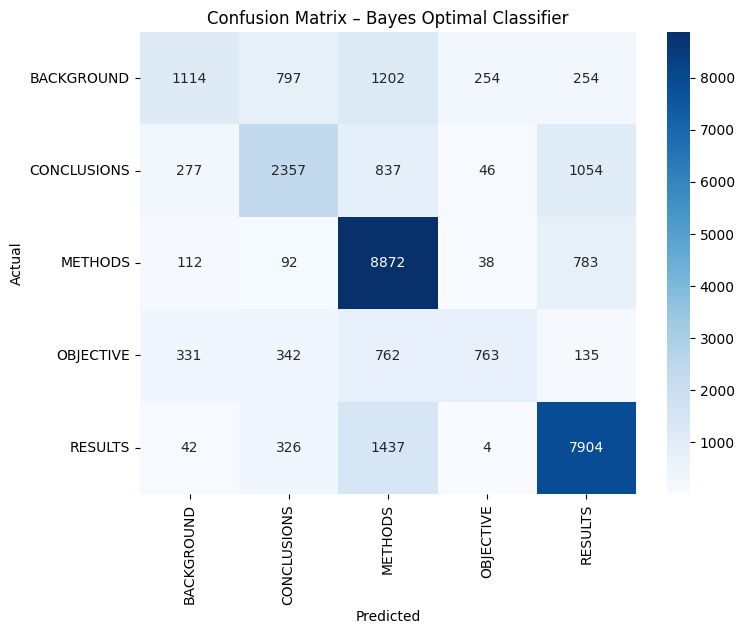

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# =======================================================
# DYNAMIC SAMPLING BASED ON SRN
# =======================================================
BASE_SAMPLE_SIZE = 10000
FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# =======================================================
# PLACEHOLDER DATA (for demo if dataset not loaded)
# =======================================================
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using placeholder data.")
    X_train = pd.Series(["sample background text"] * 6000 + ["sample methods text"] * 6000)
    y_train = pd.Series(["BACKGROUND"] * 6000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test background text", "test methods text"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

# =======================================================
# BASE TF-IDF PARAMETERS
# =======================================================
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 5
}

# =======================================================
# DEFINE 5 DIVERSE MODELS
# =======================================================
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])

h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), cv=3, method='isotonic'
    ))
])

h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'
    ))
])

h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1), cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

# =======================================================
# TRAINING BASE MODELS
# =======================================================
print("\nTraining all base models...")
for name, model in zip(hypothesis_names, hypotheses):
    print(f"→ Training {name} ...")
    model.fit(X_train_sampled, y_train_sampled)
print("All base models trained successfully.")

# =======================================================
# POSTERIOR WEIGHT CALCULATION
# =======================================================
print("\nCalculating posterior weights (P(h|D))...")
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=42
)

val_scores = []
for name, model in zip(hypothesis_names, hypotheses):
    preds = model.predict(X_val_sub)
    acc = accuracy_score(y_val_sub, preds)
    val_scores.append(acc)
    print(f"{name} validation accuracy: {acc:.4f}")

# Normalize validation scores → posterior weights
posterior_weights = np.array(val_scores) / np.sum(val_scores)
posterior_weights = posterior_weights.round(3).tolist()
print(f"\nPosterior Weights (normalized): {posterior_weights}")

# =======================================================
# BAYES OPTIMAL CLASSIFIER (SOFT VOTING)
# =======================================================
estimators = list(zip(hypothesis_names, hypotheses))
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")

# =======================================================
# FINAL EVALUATION ON TEST SET
# =======================================================
print("\nPredicting on test set...")
y_pred = boc_soft_voter.predict(X_test)

print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=target_names))
print(f"Macro F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")

# =======================================================
# CONFUSION MATRIX VISUALIZATION
# =======================================================
cm = confusion_matrix(y_test, y_pred, labels=target_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix – Bayes Optimal Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
